In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from acessar_dados_curated import carregar_parquets_em_variaveis
import seaborn as sns
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [2]:
carregar_parquets_em_variaveis(destino=globals(), nomes=["clientes_desde", "codigos_paises","contratacoes_ultimos_12_meses", "dados_clientes","historico",
                                                          "mrr","nps_relacional", "nps_transacional_aquisicao","nps_transacional_implantacao", 
                                                          "nps_transacional_onboarding","nps_transacional_produto", "nps_transacional_suporte",
                                                          "tickets", "telemetria_consolidado"])

clientes_desde ← silver/tb_clientes_desde/clientes_desde.parquet  | 10615 linhas
codigos_paises ← silver/codigos_paises/codigos_paises.parquet  | 249 linhas
contratacoes_ultimos_12_meses ← silver/tb_contratacoes_12m/contratacoes_ultimos_12_meses.parquet  | 4314 linhas
dados_clientes ← silver/tb_dados_clientes/dados_clientes.parquet  | 238597 linhas
historico ← silver/tb_historico/historico.parquet  | 22740 linhas
mrr ← silver/tb_mrr/mrr.parquet  | 7309 linhas
nps_relacional ← silver/tb_nps_relacional/nps_relacional.parquet  | 13942 linhas
nps_transacional_aquisicao ← silver/tb_nps_aquisicao/nps_transacional_aquisicao.parquet  | 175 linhas
nps_transacional_implantacao ← silver/tb_nps_implantacao/nps_transacional_implantacao.parquet  | 662 linhas
nps_transacional_onboarding ← silver/tb_nps_onboarding/nps_transacional_onboarding.parquet  | 208 linhas
nps_transacional_produto ← silver/tb_nps_produto/nps_transacional_produto.parquet  | 113201 linhas
nps_transacional_suporte ← silver/tb_nps_

{'clientes_desde': 's3://arcana-fiap/silver/tb_clientes_desde/clientes_desde.parquet',
 'codigos_paises': 's3://arcana-fiap/silver/codigos_paises/codigos_paises.parquet',
 'contratacoes_ultimos_12_meses': 's3://arcana-fiap/silver/tb_contratacoes_12m/contratacoes_ultimos_12_meses.parquet',
 'dados_clientes': 's3://arcana-fiap/silver/tb_dados_clientes/dados_clientes.parquet',
 'historico': 's3://arcana-fiap/silver/tb_historico/historico.parquet',
 'mrr': 's3://arcana-fiap/silver/tb_mrr/mrr.parquet',
 'nps_relacional': 's3://arcana-fiap/silver/tb_nps_relacional/nps_relacional.parquet',
 'nps_transacional_aquisicao': 's3://arcana-fiap/silver/tb_nps_aquisicao/nps_transacional_aquisicao.parquet',
 'nps_transacional_implantacao': 's3://arcana-fiap/silver/tb_nps_implantacao/nps_transacional_implantacao.parquet',
 'nps_transacional_onboarding': 's3://arcana-fiap/silver/tb_nps_onboarding/nps_transacional_onboarding.parquet',
 'nps_transacional_produto': 's3://arcana-fiap/silver/tb_nps_produto/np

In [3]:
df_clientes_desde = clientes_desde
df_codigos_paises = codigos_paises
df_contratacoes_ultimos_12_meses = contratacoes_ultimos_12_meses
df_dados_clientes = dados_clientes
df_historico = historico
df_mrr = mrr
df_nps_relacional = nps_relacional
df_nps_transacional_aquisicao = nps_transacional_aquisicao
df_nps_transacional_implantacao = nps_transacional_implantacao
df_nps_transacional_onboarding = nps_transacional_onboarding
df_nps_transacional_produto = nps_transacional_produto
df_nps_transacional_suporte = nps_transacional_suporte
df_telemetria_consolidado = telemetria_consolidado
df_tickets = tickets

In [4]:
# Janela de observação
HOJE = pd.to_datetime("today")

# Base mestre: clientes únicos
base = df_clientes_desde.copy()


base["TEMPO_CONTRATO_DIAS"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days)
base["TEMPO_CONTRATO_MESES"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days // 30)
base["TEMPO_CONTRATO_ANOS"] = ((HOJE - base["DATA_CLIENTE_DESDE"]).dt.days // 365)

base.head()

,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS
0,TFDICB,2023-01-27,961,32,2
1,TFCU91,2021-01-26,1692,56,4
2,TFDDYV,2022-07-18,1154,38,3
3,TEZBRW,2022-10-28,1052,35,2
4,TEZCXN,2013-05-24,4496,149,12


In [5]:
# Removendo os 2 últimos caracteres
df_telemetria_consolidado["COD_CLIENTE"] = df_telemetria_consolidado["COD_CLIENTE"].str[:-2]

In [6]:
df_telemetria_consolidado

,COD_CLIENTE,DURACAO_EVENTO,ID_MODULO,ID_LINHA_PRODUTO,DATA_REFERENCIA,ID_SLOT,STATUS_LICENCA,CLOUD,CLIENTE_PRIME
0,TEXKCV,580.724,6,2,2025-03-19,4133,Desconectado,NaN,NaN
1,TAAHTU,414787.069,6,2,2025-03-19,4000,Desconectado,NaN,NaN
2,TEXKCV,4933.511,6,2,2025-03-19,4133,Desconectado,NaN,NaN
3,TEWERU,414086.474,7,2,2025-03-19,4000,Desconectado,NaN,NaN
4,TFDFHJ,0.000,524,3,2025-03-19,0,Desconectado,NaN,NaN
...,...,...,...,...,...,...,...,...,...
30804192,TDC0GU,180.000,726,9,2025-03-18,3502,Desconectado,NaN,NaN
30804193,TDC0GU,120.000,726,9,2025-03-18,3502,Desconectado,NaN,NaN
30804194,T46457,1349.000,534,3,2025-03-18,534,Desconectado,NaN,NaN
30804195,T43087,61.000,534,3,2025-03-18,534,Desconectado,NaN,NaN


Funções de agregação por tabela

In [7]:
# DADOS_CLIENTES

def agg_dados_clientes(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_produtos=("DS_PROD", "nunique"),
        vl_total_contrato=("VL_TOTAL_CONTRATO", "mean"),
        segmento=("DS_SEGMENTO", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        subsegmento=("DS_SUBSEGMENTO", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        porte=("FAT_FAIXA", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
        modal_comercio=("MODAL_COMERC", lambda x: x.mode().iloc[0] if len(x.mode())>0 else np.nan),
    ).reset_index()
    return out

def agg_contratacoes_12m(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_contratos_12m=("QT_CONTRATACOES_12M", "sum"),
        vl_contratos_12m=("VL_CONTRATACOES_12M", "sum")
    ).reset_index()
    out["contratou_ult_12m"] = (out["n_contratos_12m"] > 0).astype(int)
    return out


def agg_nps_geral(df, prefixo):
    # Colunas numéricas de nota
    num_cols = [c for c in df.columns if c.startswith("NOTA")]
    grp = df.groupby("COD_CLIENTE")
    out = grp[num_cols].mean().add_prefix(f"{prefixo}_").reset_index()
    out[f"{prefixo}_respondeu"] = grp.size().reset_index(name="n")["n"].astype(int)
    out[f"{prefixo}_respondeu"] = (out[f"{prefixo}_respondeu"]>0).astype(int)
    return out


def agg_telemetria(df):
    out = df.groupby("COD_CLIENTE").agg(
        tele_eventos=("DURACAO_EVENTO","count"),
        tele_modulos=("ID_MODULO","nunique"),
        tele_linhas_produto=("ID_LINHA_PRODUTO","nunique"),
    ).reset_index()
    return out


def agg_tickets(df):
    # indicador de crítico
    if "PRIORIDADE_TICKET" in df.columns:
        df["is_critico"] = df["PRIORIDADE_TICKET"].astype(str).str.lower().isin(["low","normal","high","urgent"]).astype(int)
    else:
        df["is_critico"] = 0

    out = df.groupby("COD_CLIENTE").agg(
        n_tickets=("BK_TICKET","count"),
        pct_tickets_criticos=("is_critico","mean")
    ).reset_index()
    return out


def agg_historico(df):
    out = df.groupby("COD_CLIENTE").agg(
        n_propostas=("NR_PROPOSTA","nunique"),
        vl_total_propostas=("VL_TOTAL","sum"),
        prc_unitario_medio=("PRC_UNITARIO","mean")
    ).reset_index()
    return out

In [8]:
def left_merge(a, b, on="COD_CLIENTE"):
    return a.merge(b, on=on, how="left")

# Agregações
agg_dc   = agg_dados_clientes(df_dados_clientes)
agg_ct12 = agg_contratacoes_12m(df_contratacoes_ultimos_12_meses)
agg_mrr_ = df_mrr

agg_nps_rel = agg_nps_geral(df_nps_relacional, "nps_rel")
agg_nps_aq  = agg_nps_geral(df_nps_transacional_aquisicao, "nps_aquis")
agg_nps_impl= agg_nps_geral(df_nps_transacional_implantacao, "nps_impl")
agg_nps_onb = agg_nps_geral(df_nps_transacional_onboarding, "nps_onb")
agg_nps_sup = agg_nps_geral(df_nps_transacional_suporte, "nps_sup")

agg_tel  = agg_telemetria(df_telemetria_consolidado)
agg_tic  = agg_tickets(df_tickets)
agg_hist = agg_historico(df_historico)

# Join Geral
df = base.copy()
for part in [agg_dc, agg_ct12, agg_mrr_, agg_nps_rel, agg_nps_aq, agg_nps_impl, agg_nps_onb, agg_nps_sup, agg_tel, agg_tic, agg_hist]:
    df = left_merge(df, part)

# Faltantes → 0 para contagens/somas; deixam NaN para médias de NPS/valores
count_cols = [
    "n_produtos","n_contratos_12m","contratou_ult_12m","tele_eventos","tele_modulos","tele_linhas_produto",
    "n_tickets","n_propostas"
]
for c in count_cols:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Flags respondeu NPS (se não tiver, vira 0)
for c in [col for col in df.columns if c.endswith("_respondeu")]:
    df[c] = df[c].fillna(0).astype(int)

print(df.shape)
df.head()

(10615, 62)


,COD_CLIENTE,DATA_CLIENTE_DESDE,TEMPO_CONTRATO_DIAS,TEMPO_CONTRATO_MESES,TEMPO_CONTRATO_ANOS,n_produtos,vl_total_contrato,segmento,subsegmento,porte,...,nps_sup_NOTA_SATISFACAO,nps_sup_respondeu,tele_eventos,tele_modulos,tele_linhas_produto,n_tickets,pct_tickets_criticos,n_propostas,vl_total_propostas,prc_unitario_medio
0,TFDICB,2023-01-27,961,32,2,7,1842.782497,VAREJO,CONCESSIONARIA DE VEICULOS,Faixa 03 - De 15 M ate 25 M,...,NaN,NaN,0.0,0.0,0.0,369.0,1.0,0.0,NaN,NaN
1,TFCU91,2021-01-26,1692,56,4,5,1654.275888,LOGISTICA,TRANSPORTADOR,"Faixa 00 - Ate 4,5 M",...,NaN,NaN,363.0,9.0,2.0,68.0,1.0,0.0,NaN,NaN
2,TFDDYV,2022-07-18,1154,38,3,7,6282.683614,MANUFATURA,METAL-MECANICO & PLASTICO,Sem Informações de Faturamento,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
3,TEZBRW,2022-10-28,1052,35,2,1,0.004204,SERVICOS,PROVEDOR DE SERVICOS,Sem Informações de Faturamento,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
4,TEZCXN,2013-05-24,4496,149,12,45,1460.845409,MANUFATURA,METAL-MECANICO & PLASTICO,Faixa 07 - De 75 M ate 150 M,...,9.896,1.0,17771.0,40.0,3.0,709.0,1.0,7.0,44989.370466,1482.566496


In [9]:
df.isnull().sum()

COD_CLIENTE                0
DATA_CLIENTE_DESDE         0
TEMPO_CONTRATO_DIAS        0
TEMPO_CONTRATO_MESES       0
TEMPO_CONTRATO_ANOS        0
                        ... 
n_tickets                  0
pct_tickets_criticos    3742
n_propostas                0
vl_total_propostas      6562
prc_unitario_medio      6562
Length: 62, dtype: int64

In [10]:
df.columns

Index(['COD_CLIENTE', 'DATA_CLIENTE_DESDE', 'TEMPO_CONTRATO_DIAS',
       'TEMPO_CONTRATO_MESES', 'TEMPO_CONTRATO_ANOS', 'n_produtos',
       'vl_total_contrato', 'segmento', 'subsegmento', 'porte',
       'modal_comercio', 'n_contratos_12m', 'vl_contratos_12m',
       'contratou_ult_12m', 'MRR_12M', 'nps_rel_NOTA_NPS',
       'nps_rel_NOTA_RESPOSTA_UNIDADE', 'nps_rel_NOTA_SUPTEC_AGILIDADE',
       'nps_rel_NOTA_SUPTEC_ATENDIMENTO', 'nps_rel_NOTA_COMERCIAL',
       'nps_rel_NOTA_CUSTOS', 'nps_rel_NOTA_ADMFIN_ATENDIMENTO',
       'nps_rel_NOTA_SOFTWARE', 'nps_rel_NOTA_SOFTWARE_ATUALIZACAO',
       'nps_rel_respondeu', 'nps_aquis_NOTA_NPS', 'nps_aquis_NOTA_AGILIDADE',
       'nps_aquis_NOTA_CONHECIMENTO', 'nps_aquis_NOTA_CUSTO',
       'nps_aquis_NOTA_FACILIDADE', 'nps_aquis_NOTA_FLEXIBILIDADE',
       'nps_aquis_respondeu', 'nps_impl_NOTA_NPS', 'nps_impl_NOTA_METODOLOGIA',
       'nps_impl_NOTA_GESTAO', 'nps_impl_NOTA_CONHECIMENTO',
       'nps_impl_NOTA_QUALIDADE', 'nps_impl_NOTA_COMUN

In [11]:
# Exibir apenas os nomes das colunas sem valores nulos
colunas_sem_nulos = df.columns[df.notnull().all()]
print(colunas_sem_nulos)

Index(['COD_CLIENTE', 'DATA_CLIENTE_DESDE', 'TEMPO_CONTRATO_DIAS',
       'TEMPO_CONTRATO_MESES', 'TEMPO_CONTRATO_ANOS', 'n_produtos',
       'vl_total_contrato', 'segmento', 'porte', 'n_contratos_12m',
       'contratou_ult_12m', 'tele_eventos', 'tele_modulos',
       'tele_linhas_produto', 'n_tickets', 'n_propostas'],
      dtype='object')


In [12]:
# DEFININDO FEATURES FINAIS

df_final = df.copy()

df_final = df_final[["COD_CLIENTE", "TEMPO_CONTRATO_MESES", "n_produtos", "vl_total_contrato", "segmento", "porte", "n_contratos_12m", "tele_eventos", "n_tickets", "n_propostas"]]

In [13]:
df['segmento'].unique()

array(['VAREJO', 'LOGISTICA', 'MANUFATURA', 'SERVICOS', 'DISTRIBUICAO',
       'CONSTRUCAO E PROJETOS', 'EDUCACIONAL', 'AGROINDUSTRIA',
       'HOSPITALITY', 'SAUDE', 'TOTVS', 'JURIDICO', 'FINANCIAL SERVICES',
       'SUPERMERCADOS'], dtype=object)

In [14]:
df['segmento'].value_counts()

segmento
SERVICOS                 2424
VAREJO                   2185
MANUFATURA               2072
DISTRIBUICAO              861
CONSTRUCAO E PROJETOS     702
LOGISTICA                 650
HOSPITALITY               567
EDUCACIONAL               527
SAUDE                     298
AGROINDUSTRIA             204
JURIDICO                  111
FINANCIAL SERVICES         10
TOTVS                       2
SUPERMERCADOS               2
Name: count, dtype: int64

In [15]:
df['porte'].value_counts()

porte
Sem Informações de Faturamento    5059
Faixa 00 - Ate 4,5 M              1624
Faixa 02 - De 7,5 M ate 15 M       733
Faixa 03 - De 15 M ate 25 M        580
Faixa 01 - De 4,5 M ate 7,5 M      520
Faixa 07 - De 75 M ate 150 M       442
Faixa 04 - De 25 M ate 35 M        365
Faixa 06 - De 50 M ate 75 M        346
Faixa 05 - De 35 M ate 50 M        311
Faixa 08 - De 150 M ate 300 M      303
Faixa 09 - De 300 M ate 500 M      141
Faixa 11 - Acima de 850 M          115
Faixa 10 - De 500 M ate 850 M       76
Name: count, dtype: int64

In [16]:
df['porte'].unique()

array(['Faixa 03 - De 15 M ate 25 M', 'Faixa 00 - Ate 4,5 M',
       'Sem Informações de Faturamento', 'Faixa 07 - De 75 M ate 150 M',
       'Faixa 05 - De 35 M ate 50 M', 'Faixa 09 - De 300 M ate 500 M',
       'Faixa 02 - De 7,5 M ate 15 M', 'Faixa 01 - De 4,5 M ate 7,5 M',
       'Faixa 11 - Acima de 850 M', 'Faixa 08 - De 150 M ate 300 M',
       'Faixa 04 - De 25 M ate 35 M', 'Faixa 06 - De 50 M ate 75 M',
       'Faixa 10 - De 500 M ate 850 M'], dtype=object)

In [17]:
dict_porte = {
    'Sem Informações de Faturamento': 0,
    'Faixa 00 - Ate 4,5 M': 1,
    'Faixa 01 - De 4,5 M ate 7,5 M': 2,
    'Faixa 02 - De 7,5 M ate 15 M': 3,
    'Faixa 03 - De 15 M ate 25 M': 4,
    'Faixa 04 - De 25 M ate 35 M': 5,
    'Faixa 05 - De 35 M ate 50 M': 6,
    'Faixa 06 - De 50 M ate 75 M': 7,
    'Faixa 07 - De 75 M ate 150 M': 8,
    'Faixa 08 - De 150 M ate 300 M': 9,
    'Faixa 09 - De 300 M ate 500 M': 10,
    'Faixa 10 - De 500 M ate 850 M': 11,
    'Faixa 11 - Acima de 850 M': 12
}

df_final['PORTE_CLASSIFICACAO'] = df['porte'].map(dict_porte)

In [18]:
df_final

,COD_CLIENTE,TEMPO_CONTRATO_MESES,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO
0,TFDICB,32,7,1842.782497,VAREJO,Faixa 03 - De 15 M ate 25 M,0.0,0.0,369.0,0.0,4
1,TFCU91,56,5,1654.275888,LOGISTICA,"Faixa 00 - Ate 4,5 M",0.0,363.0,68.0,0.0,1
2,TFDDYV,38,7,6282.683614,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0
3,TEZBRW,35,1,0.004204,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0
4,TEZCXN,149,45,1460.845409,MANUFATURA,Faixa 07 - De 75 M ate 150 M,3.0,17771.0,709.0,7.0,8
...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,27,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,0
10611,TFBYAZ,252,36,330.724250,HOSPITALITY,Sem Informações de Faturamento,0.0,0.0,67.0,1.0,0
10612,T04630,351,36,1014.509425,SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",0.0,0.0,7.0,0.0,3
10613,TFCIUB,74,10,7066.867524,SERVICOS,Faixa 07 - De 75 M ate 150 M,0.0,4.0,5.0,0.0,8


In [19]:
features_para_modelo = df_final.drop(['COD_CLIENTE', 'porte', 'segmento', 'PORTE_CLASSIFICACAO', 'n_propostas'], axis=1)

In [20]:
features_para_modelo

,TEMPO_CONTRATO_MESES,n_produtos,vl_total_contrato,n_contratos_12m,tele_eventos,n_tickets
0,32,7,1842.782497,0.0,0.0,369.0
1,56,5,1654.275888,0.0,363.0,68.0
2,38,7,6282.683614,0.0,0.0,0.0
3,35,1,0.004204,0.0,0.0,0.0
4,149,45,1460.845409,3.0,17771.0,709.0
...,...,...,...,...,...,...
10610,27,1,64.873927,0.0,0.0,29.0
10611,252,36,330.724250,0.0,0.0,67.0
10612,351,36,1014.509425,0.0,0.0,7.0
10613,74,10,7066.867524,0.0,4.0,5.0


In [21]:
# features_para_modelo = pd.get_dummies(features_para_modelo, columns=['segmento'])

In [22]:
features_para_modelo

,TEMPO_CONTRATO_MESES,n_produtos,vl_total_contrato,n_contratos_12m,tele_eventos,n_tickets
0,32,7,1842.782497,0.0,0.0,369.0
1,56,5,1654.275888,0.0,363.0,68.0
2,38,7,6282.683614,0.0,0.0,0.0
3,35,1,0.004204,0.0,0.0,0.0
4,149,45,1460.845409,3.0,17771.0,709.0
...,...,...,...,...,...,...
10610,27,1,64.873927,0.0,0.0,29.0
10611,252,36,330.724250,0.0,0.0,67.0
10612,351,36,1014.509425,0.0,0.0,7.0
10613,74,10,7066.867524,0.0,4.0,5.0


In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_para_modelo)

print(f"\nFormato dos dados padronizados (linhas, colunas): {X_scaled.shape}")


Formato dos dados padronizados (linhas, colunas): (10615, 6)



Calculando AIC e BIC para diferentes números de clusters...


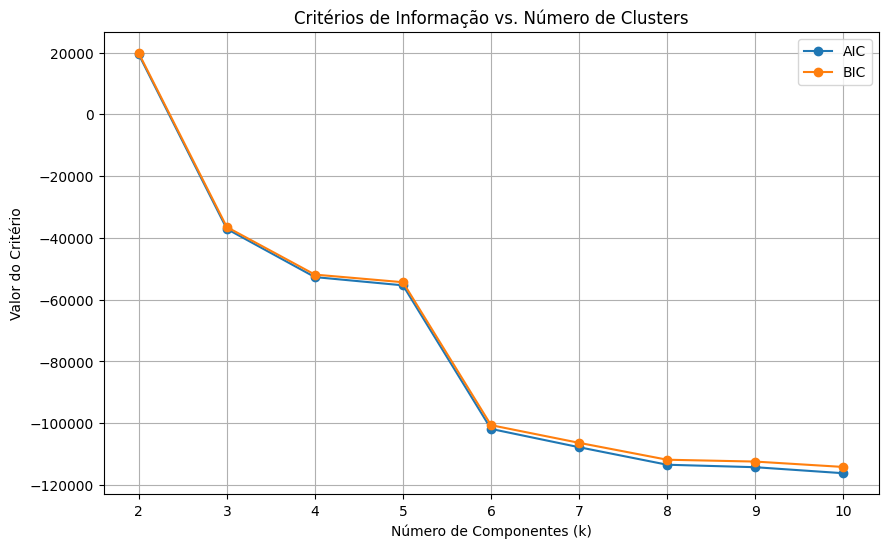


Número ideal de clusters (k) encontrado pelo BIC: 8


In [24]:
n_components = range(2, 11) # Testaremos de 2 a 10 clusters
aics = []
bics = []

print("\nCalculando AIC e BIC para diferentes números de clusters...")
for k in n_components:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    aics.append(gmm.aic(X_scaled))
    bics.append(gmm.bic(X_scaled))

# Plotando os resultados do AIC e BIC
plt.figure(figsize=(10, 6))
plt.plot(n_components, aics, marker='o', label='AIC')
plt.plot(n_components, bics, marker='o', label='BIC')
plt.title('Critérios de Informação vs. Número de Clusters')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Valor do Critério')
plt.legend()
plt.grid(True)
plt.show()

# Escolhendo o k com o menor valor de BIC, que geralmente é mais rigoroso.
optimal_k = bics.index(min(bics)) 
print(f"\nNúmero ideal de clusters (k) encontrado pelo BIC: {optimal_k}")


Calculando métricas de avaliação de cluster...


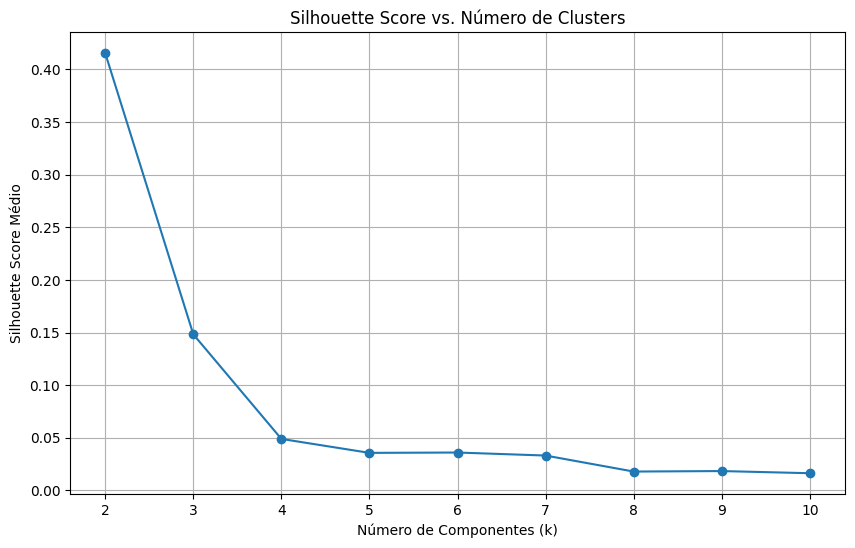


Melhor k de acordo com o Silhouette Score: 2


In [25]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

k_range = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("\nCalculando métricas de avaliação de cluster...")
for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)
    
    # Calcular e armazenar as pontuações
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

# Plotar o Silhouette Score (geralmente o mais útil)
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Número de Clusters')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Silhouette Score Médio')
plt.grid(True)
plt.show()

# O k com o MAIOR Silhouette Score é considerado o melhor por essa métrica.
best_k_silhouette = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nMelhor k de acordo com o Silhouette Score: {best_k_silhouette}")

In [26]:
gmm_final = GaussianMixture(n_components=8, random_state=42, n_init=10, covariance_type='diag')
gmm_final.fit(X_scaled)

# Prevendo os clusters para cada cliente
cluster_labels = gmm_final.fit_predict(X_scaled)

In [27]:
df_clusterizado = df_final.copy()

In [28]:
df_clusterizado['Cluster'] = cluster_labels

In [29]:
df_clusterizado

,COD_CLIENTE,TEMPO_CONTRATO_MESES,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO,Cluster
0,TFDICB,32,7,1842.782497,VAREJO,Faixa 03 - De 15 M ate 25 M,0.0,0.0,369.0,0.0,4,4
1,TFCU91,56,5,1654.275888,LOGISTICA,"Faixa 00 - Ate 4,5 M",0.0,363.0,68.0,0.0,1,4
2,TFDDYV,38,7,6282.683614,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,4
3,TEZBRW,35,1,0.004204,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,3
4,TEZCXN,149,45,1460.845409,MANUFATURA,Faixa 07 - De 75 M ate 150 M,3.0,17771.0,709.0,7.0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,27,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,0,3
10611,TFBYAZ,252,36,330.724250,HOSPITALITY,Sem Informações de Faturamento,0.0,0.0,67.0,1.0,0,4
10612,T04630,351,36,1014.509425,SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",0.0,0.0,7.0,0.0,3,4
10613,TFCIUB,74,10,7066.867524,SERVICOS,Faixa 07 - De 75 M ate 150 M,0.0,4.0,5.0,0.0,8,4


In [30]:
# Adicione a contagem de clientes ao perfil para ter tudo em uma única tabela
cluster_profile = df_clusterizado.groupby('Cluster').mean(numeric_only=True)
cluster_profile['N_Clientes'] = df_clusterizado['Cluster'].value_counts()

# Ordene pelo número de clientes para facilitar a análise
print(cluster_profile.sort_values(by='N_Clientes', ascending=False))

         TEMPO_CONTRATO_MESES  n_produtos  vl_total_contrato  n_contratos_12m  \
Cluster                                                                         
3                   85.597086    6.032153         322.921261         0.000000   
4                  147.432828   15.374865        6877.143172         0.000000   
2                  147.148233   23.110604        1597.268290         1.707526   
6                   86.470800   11.464510         796.892220         1.326146   
0                   12.208132    5.994192         405.189980         1.168441   
5                  181.206154   47.190769        3377.037654         2.484615   
1                  139.045802   15.343511       26446.121705         1.442748   
7                  185.485981   49.327103        5737.785580         5.168224   

          tele_eventos   n_tickets  n_propostas  PORTE_CLASSIFICACAO  \
Cluster                                                                
3             2.849535    9.250440     0.0070

In [31]:
df_clusterizado['Cluster'].value_counts()

Cluster
3    3981
4    1846
2    1754
6    1113
0    1033
5     650
1     131
7     107
Name: count, dtype: int64

In [32]:
df_clusterizado[df_clusterizado["Cluster"] == 3]

,COD_CLIENTE,TEMPO_CONTRATO_MESES,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO,Cluster
3,TEZBRW,35,1,0.004204,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,3
7,TDC28Q,64,3,53.557143,LOGISTICA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,3
8,TEZODM,114,4,1221.714098,CONSTRUCAO E PROJETOS,"Faixa 00 - Ate 4,5 M",0.0,0.0,5.0,0.0,1,3
9,TFCRWW,60,2,122.410021,MANUFATURA,Faixa 05 - De 35 M ate 50 M,0.0,0.0,5.0,0.0,6,3
12,TFD683,45,4,1289.381909,DISTRIBUICAO,Sem Informações de Faturamento,0.0,0.0,8.0,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
10605,TDCF4A,43,5,99.174881,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,3
10607,TDCEWK,56,3,36.394195,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,3
10609,TDCDNY,38,3,23.723768,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,3
10610,TFDNXR,27,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,0,3


In [33]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
 
gmm = GaussianMixture(n_components=8, random_state=42, covariance_type='diag').fit(features_para_modelo)
baseline = gmm.score(features_para_modelo)  # log-likelihood médio por ponto
 
for col in features_para_modelo.columns:
    X_temp = features_para_modelo.drop(columns=[col])
    gmm_temp = GaussianMixture(n_components=8, random_state=42).fit(X_temp)
    score = gmm_temp.score(X_temp)
    print(col, baseline - score)

TEMPO_CONTRATO_MESES -3.107933208327392
n_produtos -1.1732989148459616
vl_total_contrato -6.499559428341797
n_contratos_12m 1.20534785858786
tele_eventos -2.399233880181722
n_tickets -3.3518760694645593


In [34]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_tsne = tsne.fit_transform(X_scaled)

# df_plot = pd.DataFrame(X_tsne, columns=["Dim1", "Dim2"], index=df_clusterizado.index)
# df_plot["cluster"] = df_clusterizado["Cluster"]

# plt.figure(figsize=(10,7))
# for c in df_plot["cluster"].unique():
#     subset = df_plot[df_plot["cluster"] == c]
#     plt.scatter(
#         subset["Dim1"], subset["Dim2"], 
#         label=f"Cluster {c}", alpha=0.6
#     )

# plt.xlabel("Dim 1")
# plt.ylabel("Dim 2")
# plt.title("Visualização da Clusterização (t-SNE)")
# plt.legend()
# plt.show()

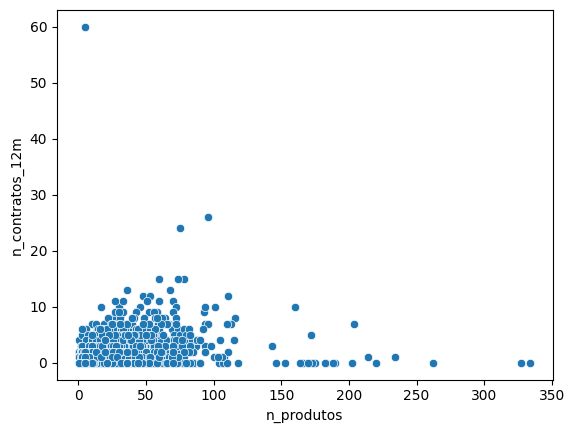

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cria o gráfico de dispersão
sns.scatterplot(data=df_clusterizado, x='n_produtos', y='n_contratos_12m')

# Mostra o gráfico
plt.show()

In [36]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.datasets import make_blobs
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture


# # 2. Rodar K-Means
# kmeans = KMeans(n_clusters=8, random_state=42)
# labels_kmeans = kmeans.fit_predict(X_scaled)

# # 3. Rodar GMM usando centróides do K-Means como inicialização
# gmm = GaussianMixture(
#     n_components=8,
#     covariance_type="full",
#     means_init=kmeans.cluster_centers_,
#     random_state=42
# )
# labels_gmm = gmm.fit_predict(X_scaled)

# # 4. Plot comparativo
# fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# # K-Means
# sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels_kmeans, palette="tab10", ax=axes[0], s=30)
# axes[0].set_title("Clusters - K-Means")

# # GMM
# sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=labels_gmm, palette="tab10", ax=axes[1], s=30)
# axes[1].set_title("Clusters - GMM")

# plt.show()

In [37]:
# df_clusterizado['Cluster'] = labels_kmeans

In [38]:
# # Adicione a contagem de clientes ao perfil para ter tudo em uma única tabela
# cluster_profile = df_clusterizado.groupby('Cluster').mean(numeric_only=True)
# cluster_profile['N_Clientes'] = df_clusterizado['Cluster'].value_counts()

# # Ordene pelo número de clientes para facilitar a análise
# print(cluster_profile.sort_values(by='N_Clientes', ascending=False))

In [39]:
# df_clusterizado['Cluster'] = labels_gmm

In [40]:
# # Adicione a contagem de clientes ao perfil para ter tudo em uma única tabela
# cluster_profile = df_clusterizado.groupby('Cluster').mean(numeric_only=True)
# cluster_profile['N_Clientes'] = df_clusterizado['Cluster'].value_counts()

# # Ordene pelo número de clientes para facilitar a análise
# print(cluster_profile.sort_values(by='N_Clientes', ascending=False))

In [41]:
df_clusterizado = df_final.copy()

In [42]:
# Importe a biblioteca correta
from sklearn.mixture import BayesianGaussianMixture
import numpy as np

# Seus dados padronizados (X_scaled) já devem estar prontos
# X_scaled = ...

# ==============================================================================
# PASSO 1: INSTANCIAR E TREINAR O MODELO BAYESIANO
# ==============================================================================

# Defina um número máximo de clusters (um limite superior)
max_clusters = 10

# Instancie o modelo
# Usamos um 'weight_concentration_prior' baixo para que ele encontre o k.
bgm = BayesianGaussianMixture(
    n_components=max_clusters,
    covariance_type='diag', # 'diag' ou 'full' costumam funcionar bem
    n_init=10,              # Ainda importante para robustez!
    random_state=42,
    weight_concentration_prior=0.1 # Experimente valores como 0.1, 0.01, 0.5
)

print("Treinando o modelo GMM Bayesiano...")
# Treine o modelo como antes
bgm.fit(X_scaled)


# ==============================================================================
# PASSO 2: DESCOBRIR QUANTOS CLUSTERS O MODELO ENCONTROU
# ==============================================================================
# A "mágica" acontece aqui. Vamos inspecionar os pesos que o modelo aprendeu.
# Clusters com peso muito baixo foram "desligados".

# bgm.weights_ contém a importância de cada um dos 'max_clusters'
pesos_dos_clusters = bgm.weights_

# Vamos considerar um cluster como "ativo" se seu peso for maior que um pequeno limiar
limiar = 0.01 # Um peso de 1%
clusters_ativos = np.sum(pesos_dos_clusters > limiar)

print(f"\nO modelo encontrou {clusters_ativos} clusters efetivos!")
print("Pesos de cada componente (clusters com peso perto de zero foram descartados):")
print(np.sort(pesos_dos_clusters)[::-1].round(3))


# ==============================================================================
# PASSO 3: ANÁLISE E VISUALIZAÇÃO (O RESTO É IGUAL!)
# ==============================================================================
# A partir daqui, o processo é exatamente o mesmo que você já fez!


bgm2 = BayesianGaussianMixture(
    n_components=clusters_ativos,
    covariance_type='diag', # 'diag' ou 'full' costumam funcionar bem
    n_init=10,              # Ainda importante para robustez!
    random_state=42,
    weight_concentration_prior=0.1 # Experimente valores como 0.1, 0.01, 0.5
)

bgm2.fit(X_scaled)

# Atribua os clusters aos seus dados originais
df_clusterizado['Cluster'] = bgm2.predict(X_scaled)

# Gere o perfil dos clusters
perfil_bayesiano = df_clusterizado.groupby('Cluster').mean(numeric_only=True)
perfil_bayesiano['N_Clientes'] = df_clusterizado['Cluster'].value_counts()

print("\n--- Perfil dos Clusters Encontrados pelo Modelo Bayesiano ---")
print(perfil_bayesiano)


# Crie o gráfico de dispersão
# A única diferença é que o 'hue' agora usa a nova coluna
# sns.scatterplot(data=df_final, x='vl_total_contrato', y='TEMPO_CONTRATO_MESES', hue='Cluster_Bayesiano')
# plt.show()

Treinando o modelo GMM Bayesiano...

O modelo encontrou 8 clusters efetivos!
Pesos de cada componente (clusters com peso perto de zero foram descartados):
[0.299 0.242 0.138 0.123 0.108 0.052 0.021 0.01  0.005 0.002]

--- Perfil dos Clusters Encontrados pelo Modelo Bayesiano ---
         TEMPO_CONTRATO_MESES  n_produtos  vl_total_contrato  n_contratos_12m  \
Cluster                                                                         
0                   70.963445    4.266729         306.205187         0.000000   
1                  178.368973   42.664570        3887.240071         2.821803   
2                  147.783268   14.860311        1138.061227         0.000000   
3                  166.254386   14.105263      112950.076538         0.649123   
4                  106.831317   13.353737        1072.015800         1.481851   
5                  215.311321   84.084906        5107.437797         4.622642   
6                  151.958522   26.937784        1987.022743         1.7

In [43]:
df_clusterizado

,COD_CLIENTE,TEMPO_CONTRATO_MESES,n_produtos,vl_total_contrato,segmento,porte,n_contratos_12m,tele_eventos,n_tickets,n_propostas,PORTE_CLASSIFICACAO,Cluster
0,TFDICB,32,7,1842.782497,VAREJO,Faixa 03 - De 15 M ate 25 M,0.0,0.0,369.0,0.0,4,6
1,TFCU91,56,5,1654.275888,LOGISTICA,"Faixa 00 - Ate 4,5 M",0.0,363.0,68.0,0.0,1,2
2,TFDDYV,38,7,6282.683614,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,2
3,TEZBRW,35,1,0.004204,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,0,0
4,TEZCXN,149,45,1460.845409,MANUFATURA,Faixa 07 - De 75 M ate 150 M,3.0,17771.0,709.0,7.0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,27,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,0,0
10611,TFBYAZ,252,36,330.724250,HOSPITALITY,Sem Informações de Faturamento,0.0,0.0,67.0,1.0,0,2
10612,T04630,351,36,1014.509425,SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",0.0,0.0,7.0,0.0,3,2
10613,TFCIUB,74,10,7066.867524,SERVICOS,Faixa 07 - De 75 M ate 150 M,0.0,4.0,5.0,0.0,8,2


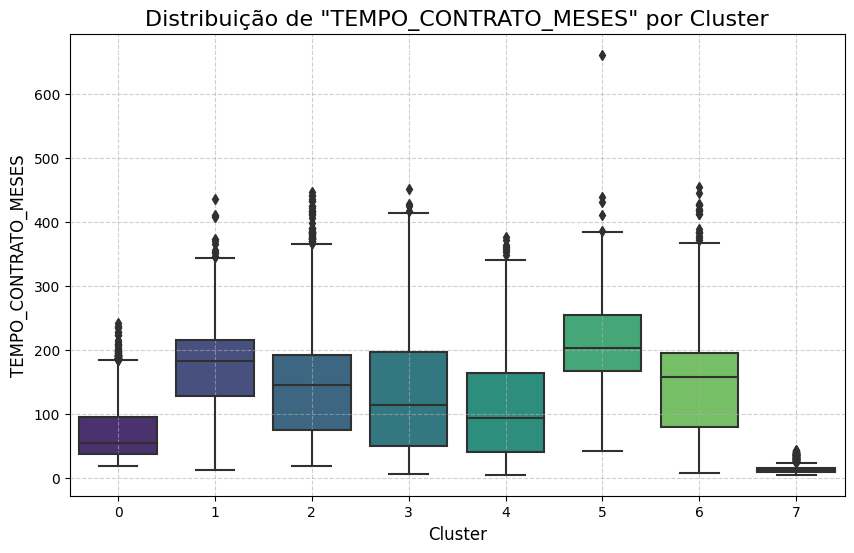

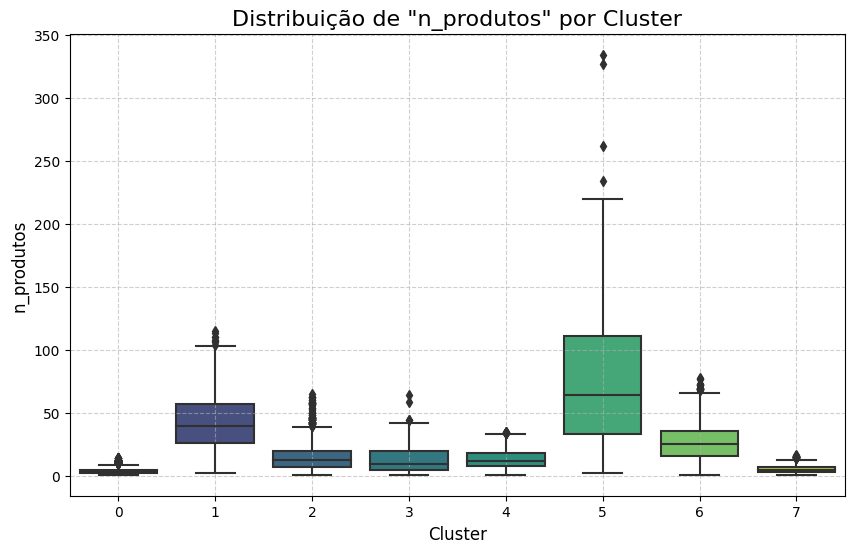

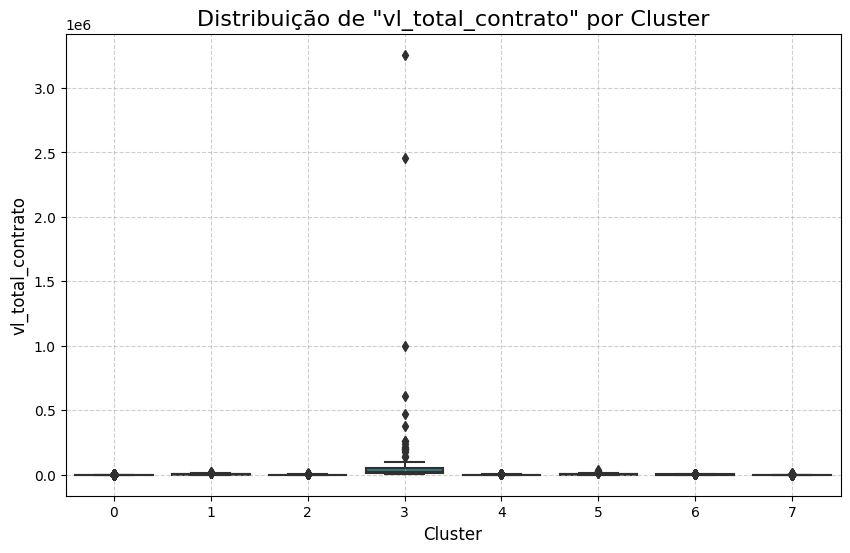

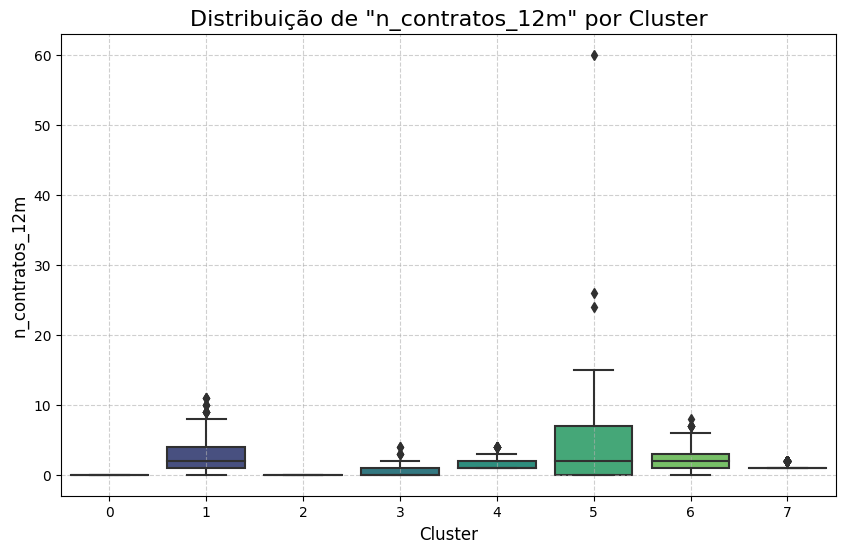

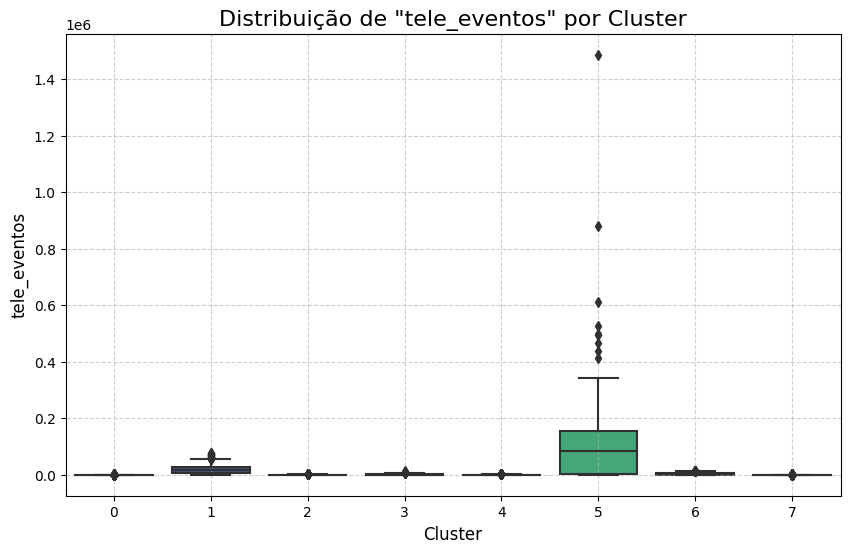

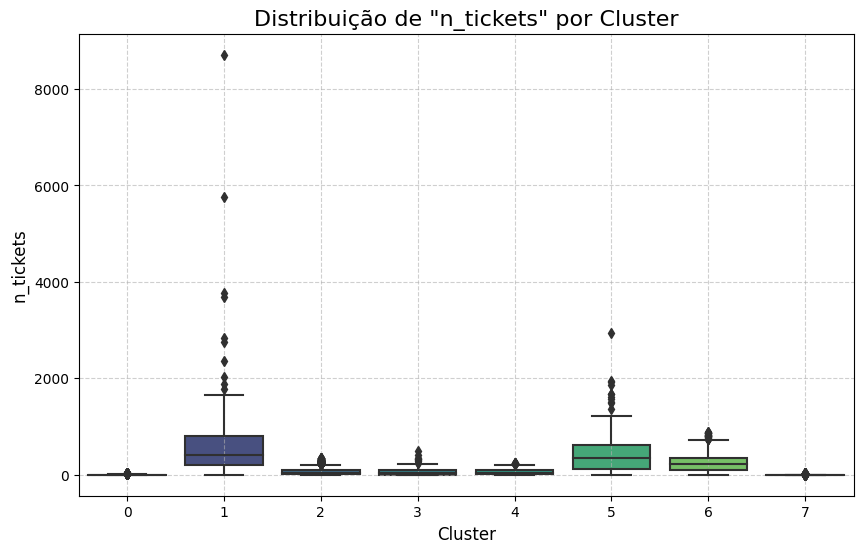

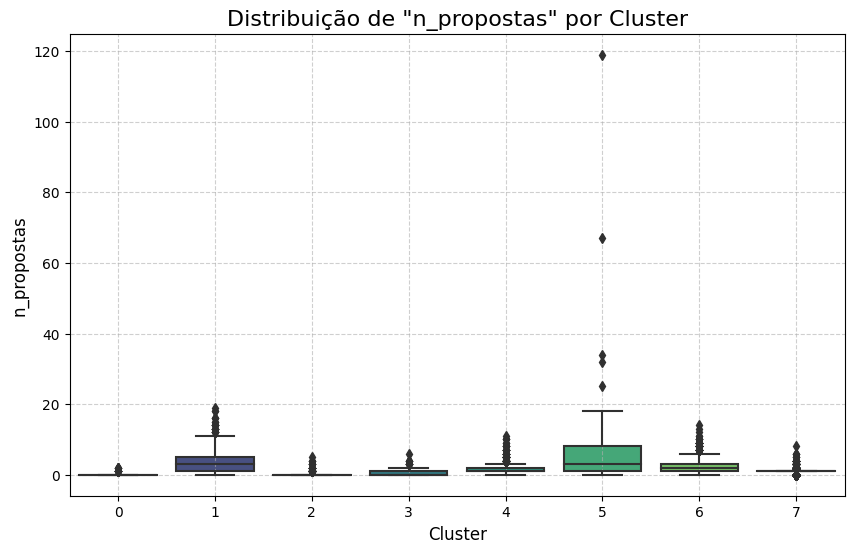

In [45]:
colunas_numericas = [
    'TEMPO_CONTRATO_MESES', 'n_produtos', 'vl_total_contrato', 
    'n_contratos_12m', 'tele_eventos', 'n_tickets', 'n_propostas'
]

for coluna in colunas_numericas:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clusterizado, x='Cluster', y=coluna, palette='viridis')
    plt.title(f'Distribuição de "{coluna}" por Cluster', fontsize=16)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel(coluna, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

In [46]:
# Tamanho absoluto
tamanho_clusters = df_clusterizado['Cluster'].value_counts().sort_index()

# Tamanho relativo (%)
proporcao_clusters = df_clusterizado['Cluster'].value_counts(normalize=True).mul(100).round(2).sort_index()

# Juntando em uma tabela resumo
overview_clusters = pd.DataFrame({
    'N_Clientes': tamanho_clusters,
    '%_Total_Clientes': proporcao_clusters
})

print("--- Visão Geral do Tamanho dos Clusters ---")
print(overview_clusters)

--- Visão Geral do Tamanho dos Clusters ---
         N_Clientes  %_Total_Clientes
Cluster                              
0              3228             30.41
1               477              4.49
2              2570             24.21
3               114              1.07
4              1405             13.24
5               106              1.00
6              1543             14.54
7              1172             11.04


In [53]:
# Lista das suas colunas numéricas de interesse
colunas_numericas = [
    'TEMPO_CONTRATO_MESES', 'n_produtos', 'vl_total_contrato', 
    'n_contratos_12m', 'tele_eventos', 'n_tickets', 'n_propostas', 'PORTE_CLASSIFICACAO'
]

# Agrupando e calculando as métricas
perfil_quantitativo = df_clusterizado.groupby('Cluster')[colunas_numericas].agg(['mean', 'median', 'std'])

print("\n--- Perfil Quantitativo Detalhado por Cluster ---")
print(perfil_quantitativo)


--- Perfil Quantitativo Detalhado por Cluster ---
        TEMPO_CONTRATO_MESES                    n_produtos                    \
                        mean median         std       mean median        std   
Cluster                                                                        
0                  70.963445   55.0   44.774336   4.266729    4.0   2.731750   
1                 178.368973  183.0   81.248207  42.664570   40.0  22.890970   
2                 147.783268  146.0   86.576283  14.860311   13.0  10.445559   
3                 166.254386  114.5  140.004792  14.105263    9.5  12.503712   
4                 106.831317   93.0   78.389564  13.353737   12.0   7.367886   
5                 215.311321  203.0   94.323795  84.084906   64.0  69.599277   
6                 151.958522  158.0   85.702020  26.937784   25.0  14.291436   
7                  13.156143   12.0    6.911075   5.702218    5.0   3.199204   

        vl_total_contrato                              n_contratos_1

In [ ]:
# Composição para a variável 'segmento'
composicao_segmento = df_clusterizado.groupby('Cluster')['segmento'].value_counts(normalize=True).mul(100).unstack(fill_value=0)

print("\n--- Composição de 'segmento' por Cluster (%) ---")
print(composicao_segmento.round(2))




--- Composição de 'segmento' por Cluster (%) ---
segmento  AGROINDUSTRIA  CONSTRUCAO E PROJETOS  DISTRIBUICAO  EDUCACIONAL  \
Cluster                                                                     
0                  1.08                   6.78          6.47         4.93   
1                  5.45                   6.29          8.18         7.34   
2                  2.14                   6.46          9.61         2.76   
3                  3.51                   7.89          3.51         0.00   
4                  1.57                   4.98         11.10         3.63   
5                  3.77                   2.83          5.66        31.13   
6                  2.85                   6.68          9.72         5.18   
7                  1.19                   8.70          4.27         8.36   

segmento  FINANCIAL SERVICES  HOSPITALITY  JURIDICO  LOGISTICA  MANUFATURA  \
Cluster                                                                      
0                      

In [50]:
composicao_porte = df_clusterizado.groupby('Cluster')['PORTE_CLASSIFICACAO'].value_counts(normalize=True).mul(100).unstack(fill_value=0)
print("\n--- Composição de 'porte' por Cluster (%) ---")
print(composicao_porte.round(2))


--- Composição de 'porte' por Cluster (%) ---
PORTE_CLASSIFICACAO     0      1     2      3      4     5     6     7   \
Cluster                                                                   
0                    76.61  14.81  1.92   2.76   0.99  0.65  0.93  0.40   
1                     7.76   3.77  4.19   4.61   6.71  7.34  7.34  7.55   
2                    26.42  25.60  8.75  11.75   8.83  4.71  3.62  3.35   
3                    41.23   4.39  0.88   3.51   4.39  5.26  3.51  6.14   
4                    37.30  19.93  6.69   9.75   8.04  4.13  3.06  4.20   
5                    16.04   3.77  0.94   3.77   2.83  3.77  4.72  6.60   
6                    15.36  10.11  5.64   9.33  10.24  7.13  6.29  8.55   
7                    89.16   2.13  2.56   2.65   0.85  0.85  0.34  0.51   

PORTE_CLASSIFICACAO     8      9     10    11     12  
Cluster                                               
0                     0.40   0.19  0.09  0.15   0.09  
1                    12.79  13.00  8.

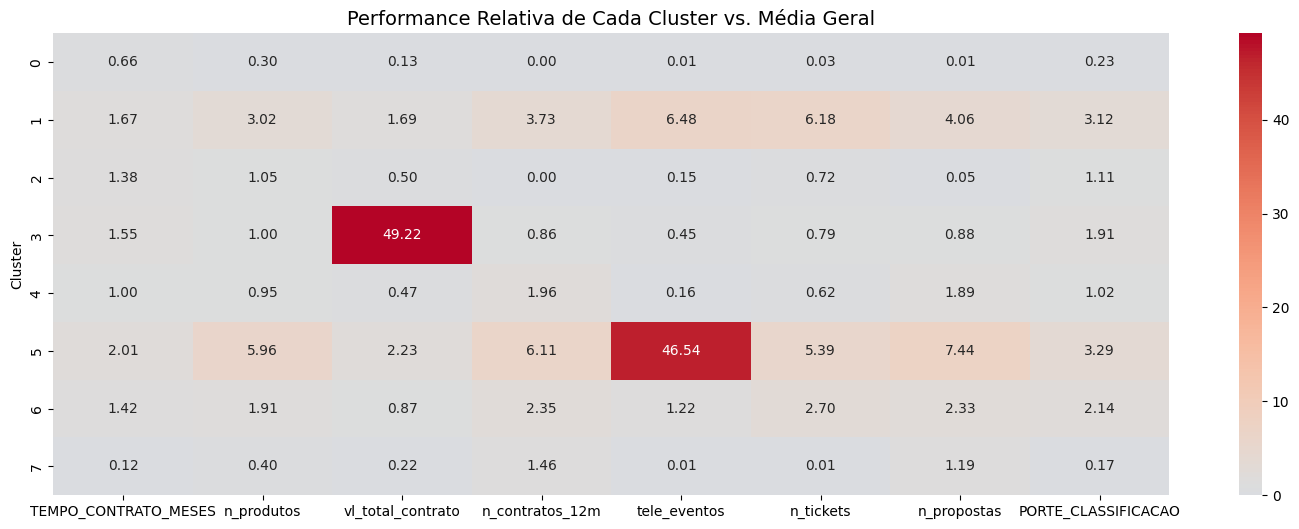

In [55]:
# Calcula as médias de cada cluster
medias_clusters = df_clusterizado.groupby('Cluster')[colunas_numericas].mean()

# Calcula a média geral da base de clientes
media_geral = df_clusterizado[colunas_numericas].mean()

# Calcula a performance relativa (razão) e centraliza em 1 (1 = igual à média)
performance_relativa = medias_clusters / media_geral

# Visualizando com um Mapa de Calor (Heatmap)
plt.figure(figsize=(18, 6))
sns.heatmap(
    performance_relativa,
    annot=True,       # Mostra os números dentro das células
    fmt='.2f',        # Formata com 2 casas decimais
    cmap='coolwarm',  # Paleta de cores (azul < 1, vermelho > 1)
    center=1.0        # Centraliza a cor em 1.0
)
plt.title('Performance Relativa de Cada Cluster vs. Média Geral', fontsize=14)
plt.show()

In [56]:
df_consolidado = left_merge(df_clusterizado, df, on="COD_CLIENTE")

In [57]:
df_consolidado

,COD_CLIENTE,TEMPO_CONTRATO_MESES_x,n_produtos_x,vl_total_contrato_x,segmento_x,porte_x,n_contratos_12m_x,tele_eventos_x,n_tickets_x,n_propostas_x,...,nps_sup_NOTA_SATISFACAO,nps_sup_respondeu,tele_eventos_y,tele_modulos,tele_linhas_produto,n_tickets_y,pct_tickets_criticos,n_propostas_y,vl_total_propostas,prc_unitario_medio
0,TFDICB,32,7,1842.782497,VAREJO,Faixa 03 - De 15 M ate 25 M,0.0,0.0,369.0,0.0,...,NaN,NaN,0.0,0.0,0.0,369.0,1.0,0.0,NaN,NaN
1,TFCU91,56,5,1654.275888,LOGISTICA,"Faixa 00 - Ate 4,5 M",0.0,363.0,68.0,0.0,...,NaN,NaN,363.0,9.0,2.0,68.0,1.0,0.0,NaN,NaN
2,TFDDYV,38,7,6282.683614,MANUFATURA,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
3,TEZBRW,35,1,0.004204,SERVICOS,Sem Informações de Faturamento,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
4,TEZCXN,149,45,1460.845409,MANUFATURA,Faixa 07 - De 75 M ate 150 M,3.0,17771.0,709.0,7.0,...,9.896,1.0,17771.0,40.0,3.0,709.0,1.0,7.0,44989.370466,1482.566496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10610,TFDNXR,27,1,64.873927,VAREJO,Sem Informações de Faturamento,0.0,0.0,29.0,0.0,...,NaN,NaN,0.0,0.0,0.0,29.0,1.0,0.0,NaN,NaN
10611,TFBYAZ,252,36,330.724250,HOSPITALITY,Sem Informações de Faturamento,0.0,0.0,67.0,1.0,...,10.000,1.0,0.0,0.0,0.0,67.0,1.0,1.0,2808.479400,75.904849
10612,T04630,351,36,1014.509425,SERVICOS,"Faixa 02 - De 7,5 M ate 15 M",0.0,0.0,7.0,0.0,...,NaN,NaN,0.0,0.0,0.0,7.0,1.0,0.0,NaN,NaN
10613,TFCIUB,74,10,7066.867524,SERVICOS,Faixa 07 - De 75 M ate 150 M,0.0,4.0,5.0,0.0,...,NaN,NaN,4.0,1.0,1.0,5.0,1.0,0.0,NaN,NaN
